# Generative Adversarial Networks

Применение adversarial loss (более общей идеи, лежащей в основе GANов) позволило решить задачи, которые казались невозможными:

* [Машинный перевод без параллельных данных](https://arxiv.org/pdf/1710.11041.pdf)
* [Циклоганы: перевод изображений в другой домен](https://arxiv.org/abs/1703.10593)
* Колоризация и [Super Resolution](https://arxiv.org/abs/1807.02758)
* [Генерация и морфинг произвольных данных](https://arxiv.org/pdf/1809.11096.pdf) ([тут](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/biggan_generation_with_tf_hub.ipynb#scrollTo=HuCO9tv3IKT2) можно поиграться с генерацией бургеров)
* Применения в борьбе с adversarial атаками

Вот постоянно пополняющийся список приложений GANов: https://github.com/nashory/gans-awesome-applications

Сама [статья](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) Яна Гудфеллоу про GANы вышла в конце 2014 года и была процитирована 7687 раз за 4 года.


<img width='500px' src='https://cdn-images-1.medium.com/max/800/1*eWURQXT41pwHvDg1xDiEmw.png'>

Теперь немного формальных определений:

* Пусть $z$ — это вектор из латентного пространства, насэмпленный из нормального распределения.
* $G(z)$ обозначает функцию генератора, которая отображает латентный вектор в пространство данных. Цель $G$ — оценить истинное распределение данных $p_d$, чтобы сэмплировать данные из оцененного распределения $p_g$.
* $D(G(z))$ это вероятность (число от 0 до 1), что выход генератора $G$ является реальным изображением.

$D$ и $G$ играют в минимаксную игру, в которой $D$ старается максимизировать вероятность, что он правильно классифицирует реальные и сгенерированные сэмплы, а $G$ старается минимизировать эту вероятность:

$$\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(x)))\big]$$

[Выясняется](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), что решение в этой минимаксной игре достигается при $p_g = p_d$ (и дискриминатор в этом случае может угадывать случайно). В реальности модели не всегда могут сойтись к этой точке.

[DCGAN](https://arxiv.org/pdf/1511.06434.pdf) (Deep Convolutional GAN) называют GAN, который явно использует свёртки и транспонированные свёртки в дискриминаторе и генераторе соответственно. Откройте статью -- мы будем идти очень близко с авторами.

## Датасет
Всем надоели цифры, поэтому обучаться мы будем на датасете CelebA ([Large-scale CelebFaces Attributes](Large-scale CelebFaces Attributes)). В датасете на каждую фотку есть её аттрибуты, но мы их пока использовать не будем.

<img width='500px' src='http://mmlab.ie.cuhk.edu.hk/projects/celeba/overview.png'>

Автор, когда готовил эту тетрадку, долго думал, как загрузить датасет, чтобы всем было удобно. Это оказалось трудно, потому что прямых ссылок на него нигде нет, и, соответственно, просто сделать `!wget ...` нельзя. По удачному стечению обстоятельств, неделю назад кто-то [добавил](https://github.com/pytorch/vision/blob/master/torchvision/datasets/celeba.py) скрипты для загрузки этого датасета в сам `torchvision`, но в `pip` новая версия за такой срок ещё не успела появиться, поэтому мы обновимся напрямую из репозитория на гитхабе:

In [1]:
!pip install git+https://github.com/pytorch/vision.git

  Cloning https://github.com/pytorch/vision.git to /tmp/pip-req-build-wwneuh9w
  Stored in directory: /tmp/pip-ephem-wheel-cache-gtvwtut0/wheels/04/6d/bf/cc14a58bae32d07d1c7d23833dc5ea655e477ff25061b8cd57
Successfully built torchvision
fastai 1.0.50.post1 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: torchvision 0.2.2.post3
    Uninstalling torchvision-0.2.2.post3:
      Successfully uninstalled torchvision-0.2.2.post3


In [0]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
device = torch.device('cuda:0')  # не забудьте включить GPU

image_size = 64
batch_size = 64

In [4]:
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # Normalize здесь приводит значения в промежуток [-1, 1]
])

dataset = datasets.CelebA('data', download=True, transform=transform)

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

1443490838it [00:12, 112700320.49it/s]
26721026it [00:00, 60563902.72it/s]
3424458it [00:00, 151244304.73it/s]
6082035it [00:00, 27879645.74it/s]
12156055it [00:00, 30296840.97it/s]
2836386it [00:00, 126970896.79it/s]


In [5]:
dataset[5][0]

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  0.8118,  0.8039,  0.7961],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.8118,  0.8039,  0.7961],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.8118,  0.8039,  0.7961],
         ...,
         [ 0.9843,  0.9843,  0.9922,  ...,  0.3333,  0.6706,  0.7725],
         [ 0.9686,  0.9686,  0.9765,  ...,  0.1451,  0.4431,  0.5843],
         [ 0.9922,  0.9922,  0.9843,  ..., -0.0902,  0.1059,  0.2078]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  0.8118,  0.8039,  0.7961],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.8118,  0.8039,  0.7961],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.8118,  0.8039,  0.7961],
         ...,
         [ 1.0000,  1.0000,  1.0000,  ...,  0.3255,  0.6784,  0.7490],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.1137,  0.4275,  0.5686],
         [ 0.9922,  0.9922,  0.9922,  ..., -0.1373,  0.0824,  0.1922]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  0.8118,  0.8039,  0.7961],
         [ 1.0000,  1.0000,  1.0000,  ...,  0

In [0]:
# посмотрите на данные (вы писали нужный код в колоризации)
# ...

## Модель

Генератор $G$ преобразует латентный вектор $z$ в пространство данных (в нашем случае -- картинки 3x64x64). В статье используют последовательность блоков из транспонированных свёрток, BatchNorm-ов и ReLU. На выходе каждое значение лежит в [-1, 1] (мы делаем TanH), в соответствии с нормализацией, которую мы сделали раньше.

<img width='600px' src='https://pytorch.org/tutorials/_images/dcgan_generator.png'>

In [0]:
device = torch.device('cuda:0')

In [0]:
num_channels = 3
latent_size = 100
base_size = 64

G = nn.Sequential(
    # input is Z, going into a convolution
    nn.ConvTranspose2d(latent_size, base_size * 8, 4, 1, 0, bias=False),
    nn.BatchNorm2d(base_size * 8),
    nn.ReLU(True),
    
    # (base_size*8) x 4 x 4
    nn.ConvTranspose2d(base_size * 8, base_size * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 4),
    nn.ReLU(True),
    
    # (base_size*4) x 8 x 8
    nn.ConvTranspose2d(base_size * 4, base_size * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 2),
    nn.ReLU(True),
    
    # (base_size*2) x 16 x 16
    nn.ConvTranspose2d(base_size * 2, base_size, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size),
    nn.ReLU(True),
    
    # (base_size) x 32 x 32
    nn.ConvTranspose2d(base_size, num_channels, 4, 2, 1, bias=False),
    nn.Tanh()
    # (num_channels) x 64 x 64
).to(device)

In [9]:
z = torch.randn(1, latent_size, 1, 1).to(device)
G(z).shape

torch.Size([1, 3, 64, 64])

Дискриминатор -- это обычный бинарный классификатор. В статье он устроен симметрично генератору: Conv2d, BatchNorm, ReLU, Conv2d...

In [0]:

D = nn.Sequential(

    nn.Conv2d(num_channels, base_size , 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(base_size, base_size * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 2),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*2) x 16 x 16
    nn.Conv2d(base_size * 2, base_size * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 4),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*4) x 8 x 8
    nn.Conv2d(base_size * 4, base_size * 8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 8),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*8) x 4 x 4
    nn.Conv2d(base_size * 8, 1, 4, 1, 0, bias=False),
    nn.Sigmoid()
).to(device)

In [11]:
z = torch.randn(64, latent_size, 1, 1).to(device)
D(G(z.to(device))).shape

torch.Size([64, 1, 1, 1])

In [12]:
for i,_ in loader:
  print(D(i.to(device)).shape)
  break

torch.Size([64, 1, 1, 1])


В статье акцентируют внимание на необходимость нестандартной инициализации весов.

In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# apply рекурсивно применяет применяет функцию ко всем своим подмодулям
G.apply(weights_init)
D.apply(weights_init)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Sigmoid()
)

## Обучение

У GANов, помимо сходимости, есть проблема, что их непонятно, как сравнивать между собой, потому что у нас не один лосс, а два. Поэтому полезнее во время обучения смотреть на генерируемые картинки, а не цифры.

In [0]:
def to_numpy_image(img):
    img=img.detach().cpu().view(64, 64,3).numpy()
    return img

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0/5, 0.0
  G loss: 11.803325653076172
  D loss: 1.847904920578003



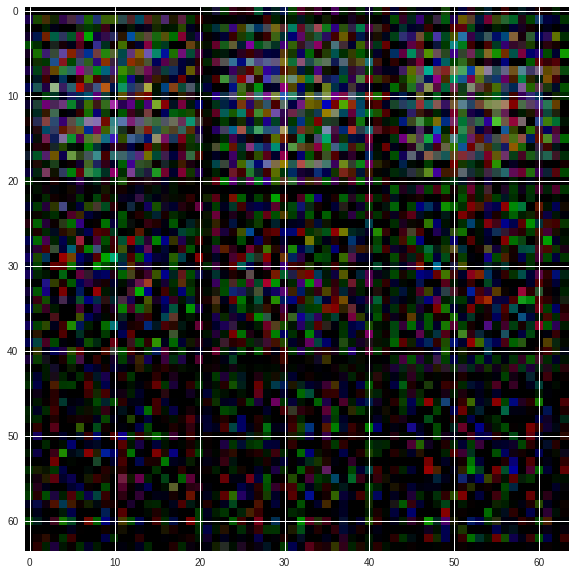

0/5, 0.019654088050314465
  G loss: 13.207856178283691
  D loss: 0.6324990391731262

0/5, 0.03930817610062893
  G loss: 9.289091110229492
  D loss: 0.03527107834815979

0/5, 0.0589622641509434
  G loss: 11.057186126708984
  D loss: 0.15753547847270966



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0/5, 0.07861635220125786
  G loss: 8.82079029083252
  D loss: 0.053116753697395325



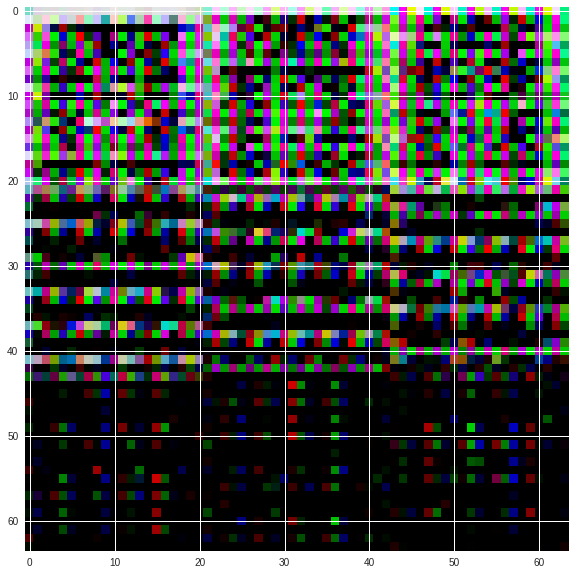

0/5, 0.09827044025157233
  G loss: 9.80102252960205
  D loss: 0.009564906358718872

0/5, 0.1179245283018868
  G loss: 14.43575382232666
  D loss: 0.0013690207852050662

0/5, 0.13757861635220126
  G loss: 16.871536254882812
  D loss: 0.05275429040193558



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0/5, 0.15723270440251572
  G loss: 24.85525894165039
  D loss: 1.5835518836975098



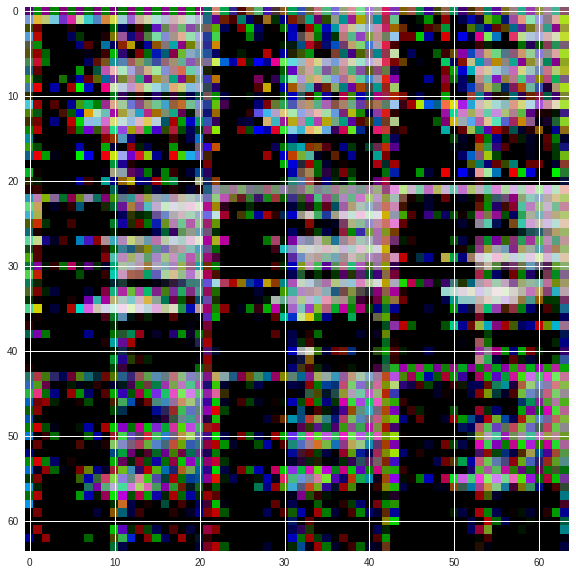

0/5, 0.17688679245283018
  G loss: 10.636266708374023
  D loss: 0.21755868196487427

0/5, 0.19654088050314467
  G loss: 11.648721694946289
  D loss: 0.04485432803630829

0/5, 0.21619496855345913
  G loss: 9.254457473754883
  D loss: 0.014815006405115128



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0/5, 0.2358490566037736
  G loss: 15.307449340820312
  D loss: 0.14712867140769958



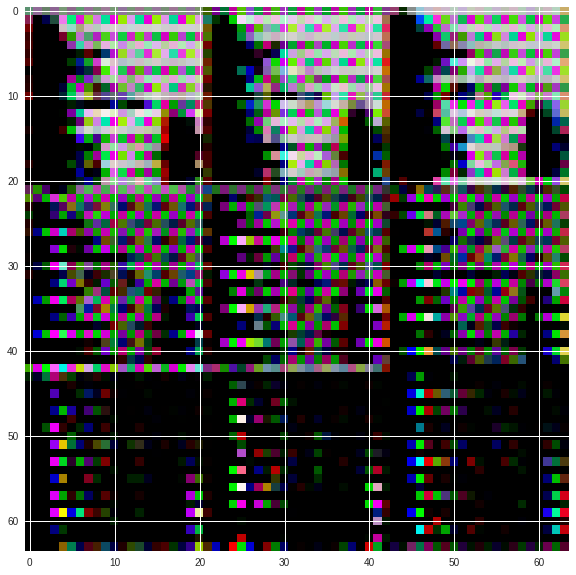

0/5, 0.2555031446540881
  G loss: 10.664276123046875
  D loss: 0.05309520661830902

0/5, 0.2751572327044025
  G loss: 8.944032669067383
  D loss: 0.030275259166955948

0/5, 0.294811320754717
  G loss: 10.032052993774414
  D loss: 0.10867132246494293



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0/5, 0.31446540880503143
  G loss: 6.915037155151367
  D loss: 0.02646797150373459



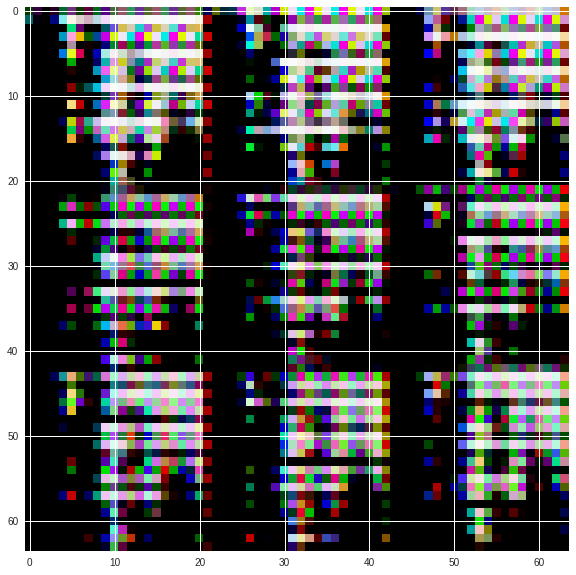

0/5, 0.3341194968553459
  G loss: 6.208131790161133
  D loss: 0.06570503115653992

0/5, 0.35377358490566035
  G loss: 8.280091285705566
  D loss: 0.011585366912186146

0/5, 0.37342767295597484
  G loss: 7.962211608886719
  D loss: 0.06617339700460434



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0/5, 0.39308176100628933
  G loss: 11.42180061340332
  D loss: 0.0053787194192409515



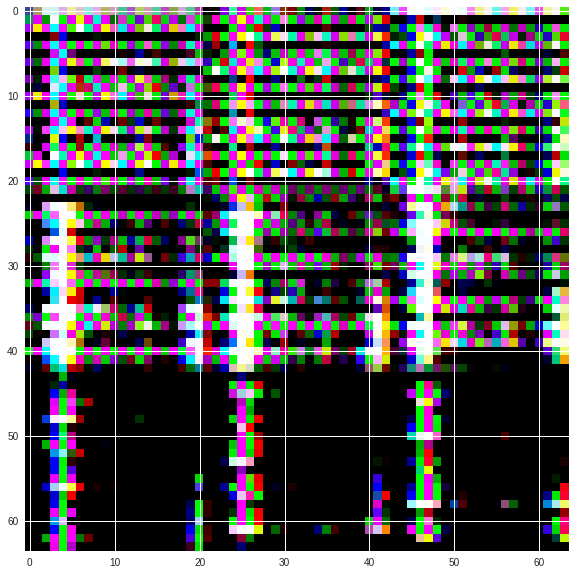

0/5, 0.41273584905660377
  G loss: 10.072626113891602
  D loss: 0.010783610865473747

0/5, 0.43238993710691825
  G loss: 8.466777801513672
  D loss: 0.0055884323082864285

0/5, 0.4520440251572327
  G loss: 15.814594268798828
  D loss: 0.21923314034938812



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0/5, 0.4716981132075472
  G loss: 12.472562789916992
  D loss: 0.013868551701307297



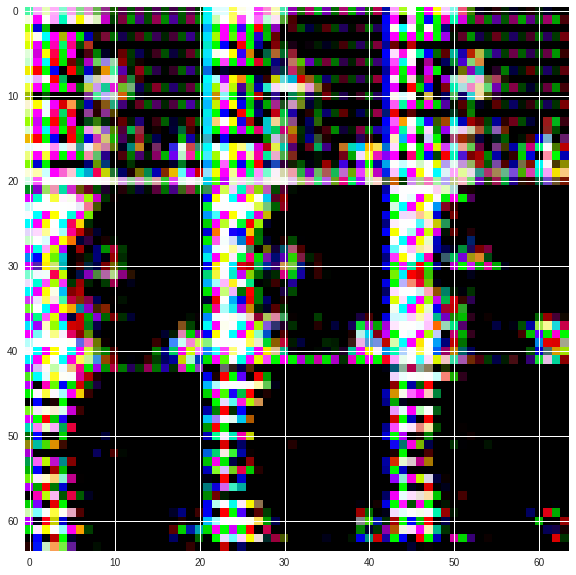

0/5, 0.4913522012578616
  G loss: 7.807624340057373
  D loss: 0.047562286257743835

0/5, 0.5110062893081762
  G loss: 9.42704963684082
  D loss: 0.02431650273501873

0/5, 0.5306603773584906
  G loss: 9.784618377685547
  D loss: 0.01915103755891323



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0/5, 0.550314465408805
  G loss: 9.266332626342773
  D loss: 0.017121385782957077



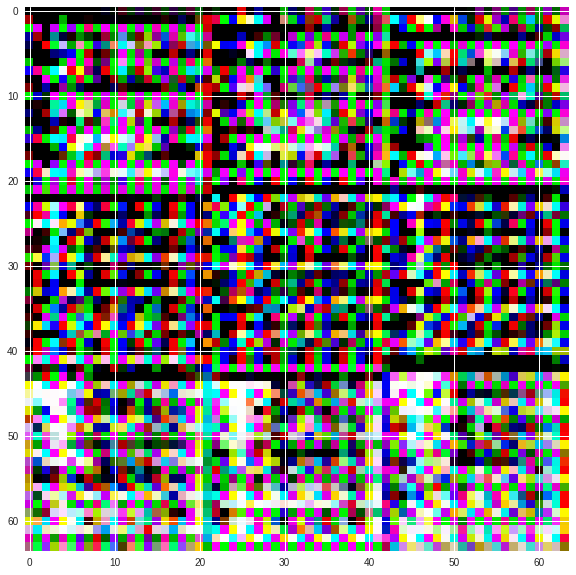

0/5, 0.5699685534591195
  G loss: 11.997343063354492
  D loss: 0.005830829963088036

0/5, 0.589622641509434
  G loss: 11.696273803710938
  D loss: 0.008215729147195816

0/5, 0.6092767295597484
  G loss: 12.009568214416504
  D loss: 0.0011882748221978545



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0/5, 0.6289308176100629
  G loss: 12.668545722961426
  D loss: 0.0047330171801149845



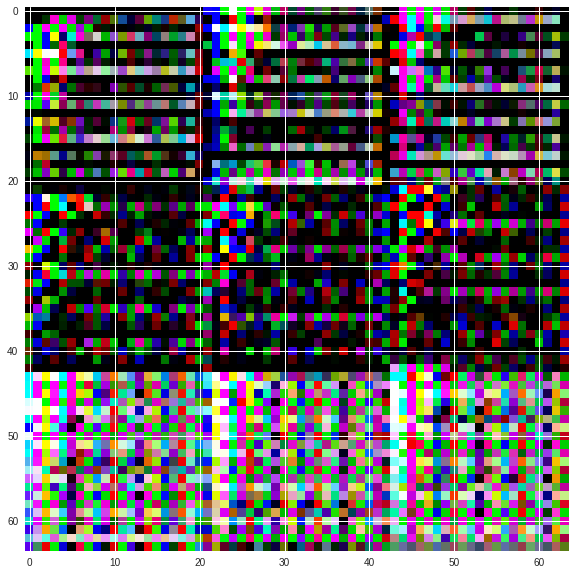

0/5, 0.6485849056603774
  G loss: 21.18096923828125
  D loss: 0.06274224817752838

0/5, 0.6682389937106918
  G loss: 55.583953857421875
  D loss: 1.341105502206119e-07

0/5, 0.6878930817610063
  G loss: 55.3111457824707
  D loss: 5.960465898624534e-08



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0/5, 0.7075471698113207
  G loss: 55.74274444580078
  D loss: 2.607715714475489e-07



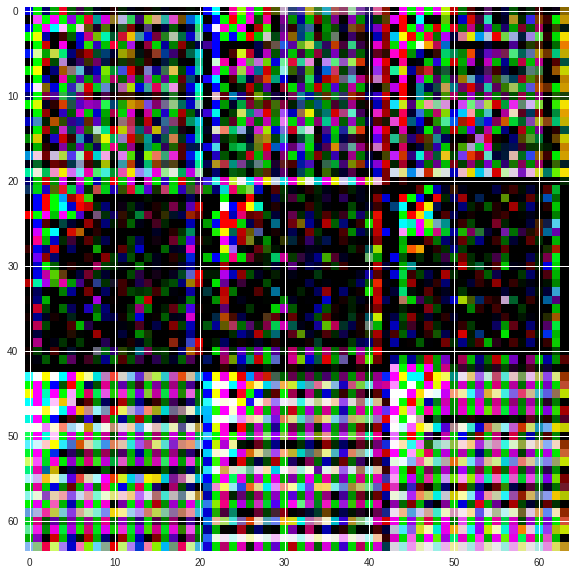

0/5, 0.7272012578616353
  G loss: 55.829322814941406
  D loss: 6.332996349556197e-08

0/5, 0.7468553459119497
  G loss: 55.606689453125
  D loss: 2.980233659855003e-08

0/5, 0.7665094339622641
  G loss: 55.097816467285156
  D loss: 7.450581485102248e-09



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0/5, 0.7861635220125787
  G loss: 55.55049133300781
  D loss: 1.9930338623908028e-07



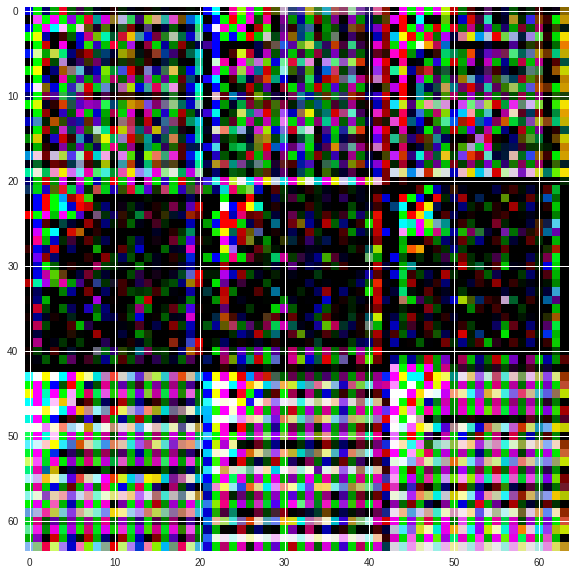

0/5, 0.8058176100628931
  G loss: 55.74346160888672
  D loss: 1.8347590184930596e-06

0/5, 0.8254716981132075
  G loss: 55.56752014160156
  D loss: 4.228235752634646e-07

0/5, 0.845125786163522
  G loss: 55.390220642089844
  D loss: 1.8440204030412133e-07



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0/5, 0.8647798742138365
  G loss: 55.70935821533203
  D loss: 2.3452075765817426e-06



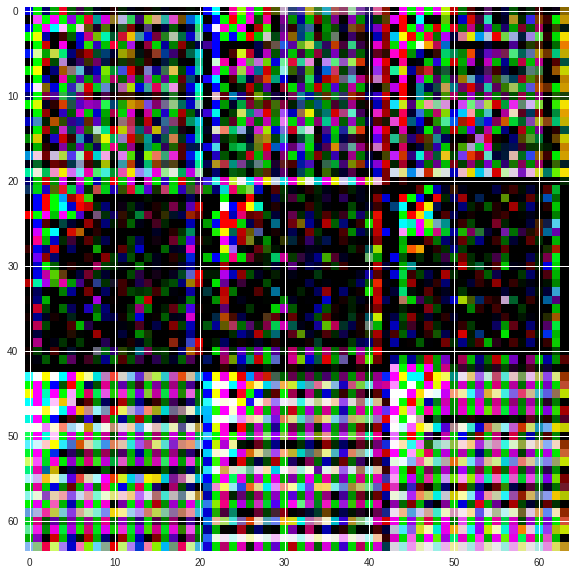

0/5, 0.8844339622641509
  G loss: 55.47909164428711
  D loss: 3.725290742551124e-09

0/5, 0.9040880503144654
  G loss: 55.259822845458984
  D loss: 2.75672363159174e-07

0/5, 0.9237421383647799
  G loss: 55.975860595703125
  D loss: 1.1548419820428535e-07



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0/5, 0.9433962264150944
  G loss: 55.49478530883789
  D loss: 5.401672709126615e-08



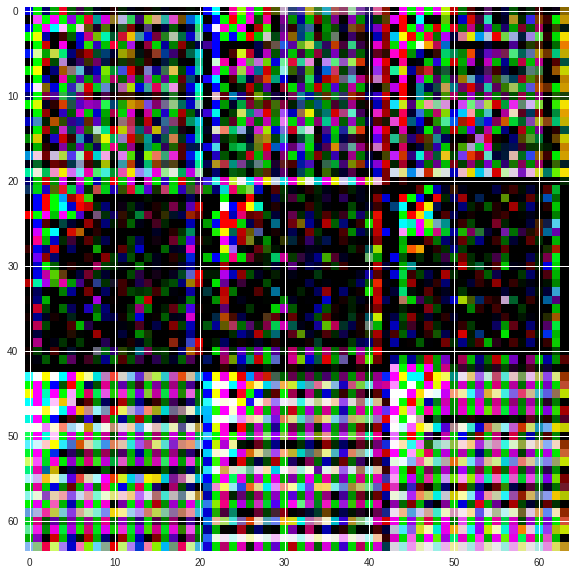

0/5, 0.9630503144654088
  G loss: 55.734649658203125
  D loss: 9.685770407941163e-08

0/5, 0.9827044025157232
  G loss: 55.66291046142578
  D loss: 1.3038517820973539e-08



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([18, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Error
1/5, 1.0023584905660377
  G loss: 55.46168518066406
  D loss: 4.470362284791918e-07



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/5, 1.0220125786163523
  G loss: 55.38926696777344
  D loss: 7.450586281265714e-08



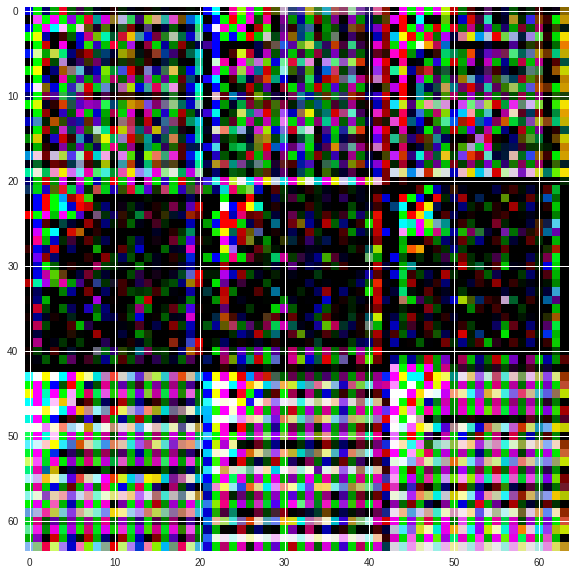

1/5, 1.0416666666666667
  G loss: 55.21454620361328
  D loss: 1.3038517820973539e-08

1/5, 1.0613207547169812
  G loss: 55.539268493652344
  D loss: 2.2351745343485163e-08

1/5, 1.0809748427672956
  G loss: 55.2156982421875
  D loss: 1.862645682138009e-08



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/5, 1.10062893081761
  G loss: 55.840484619140625
  D loss: 5.32498143002158e-06



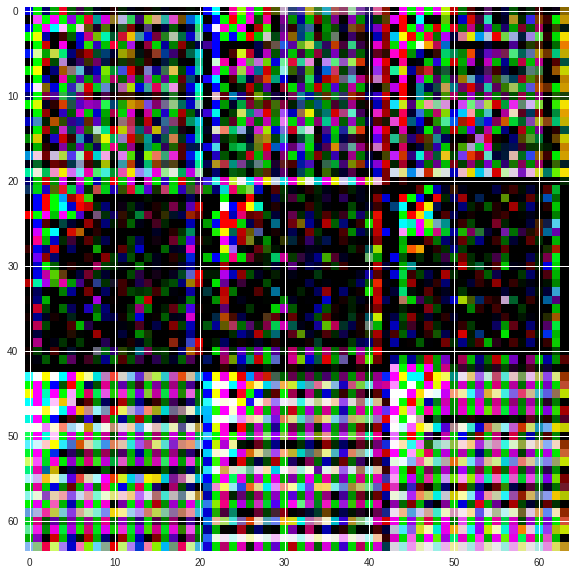

1/5, 1.1202830188679245
  G loss: 55.494712829589844
  D loss: 3.352762689701194e-08

1/5, 1.139937106918239
  G loss: 55.63695526123047
  D loss: 7.450581485102248e-09

1/5, 1.1595911949685536
  G loss: 55.4132080078125
  D loss: 5.960468030252741e-08



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/5, 1.179245283018868
  G loss: 55.23072052001953
  D loss: 2.980233659855003e-08



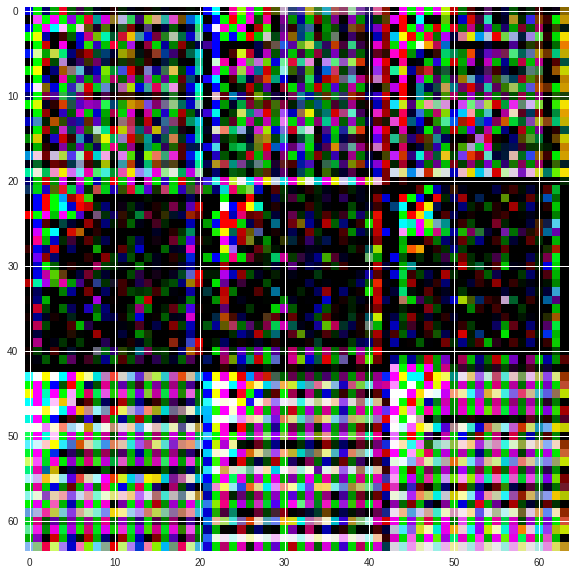

1/5, 1.1988993710691824
  G loss: 55.64753723144531
  D loss: 7.450695420629927e-07

1/5, 1.2185534591194969
  G loss: 55.29048538208008
  D loss: 6.891791315410956e-08

1/5, 1.2382075471698113
  G loss: 55.524940490722656
  D loss: 1.8087089301843662e-06



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/5, 1.2578616352201257
  G loss: 55.854164123535156
  D loss: 4.656613938891496e-08



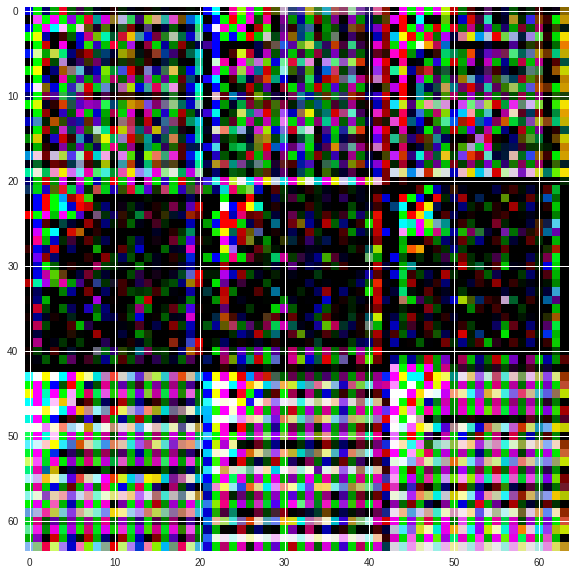

1/5, 1.2775157232704402
  G loss: 55.52217102050781
  D loss: 2.216561938439554e-07

1/5, 1.2971698113207548
  G loss: 55.620479583740234
  D loss: 1.4901164746561335e-08

1/5, 1.3168238993710693
  G loss: 55.606964111328125
  D loss: 9.313233562124879e-08



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/5, 1.3364779874213837
  G loss: 55.502296447753906
  D loss: 1.3969881251796323e-07



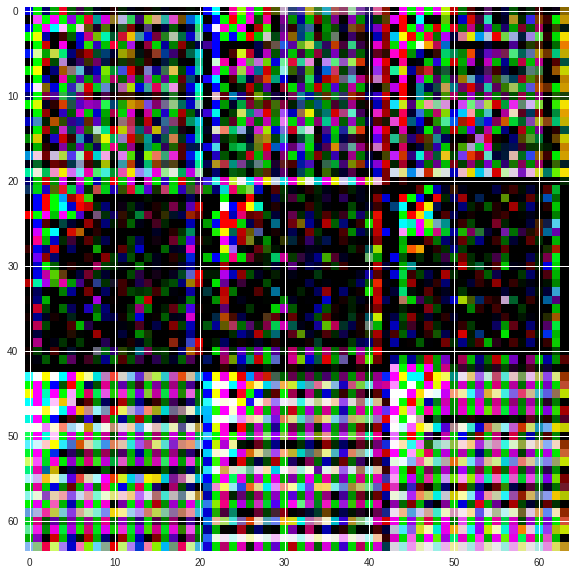

1/5, 1.3561320754716981
  G loss: 55.50110626220703
  D loss: 4.4703497792397684e-08

1/5, 1.3757861635220126
  G loss: 55.42865753173828
  D loss: 7.450581485102248e-09

1/5, 1.395440251572327
  G loss: 55.22874450683594
  D loss: 3.725290742551124e-09



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/5, 1.4150943396226414
  G loss: 55.66401672363281
  D loss: 4.284087040673512e-08



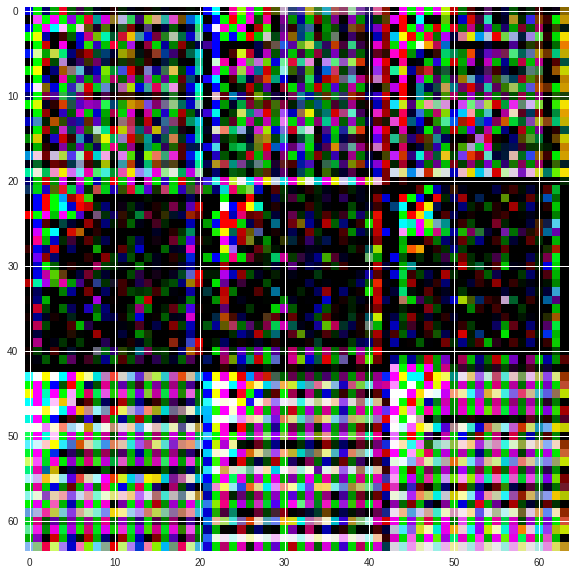

1/5, 1.434748427672956
  G loss: 55.50642395019531
  D loss: 1.1175872671742582e-08

1/5, 1.4544025157232705
  G loss: 55.212158203125
  D loss: 2.1365995053201914e-06

1/5, 1.474056603773585
  G loss: 55.80293273925781
  D loss: 9.313227522511625e-09



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/5, 1.4937106918238994
  G loss: 55.32789611816406
  D loss: 1.1734700677834553e-07



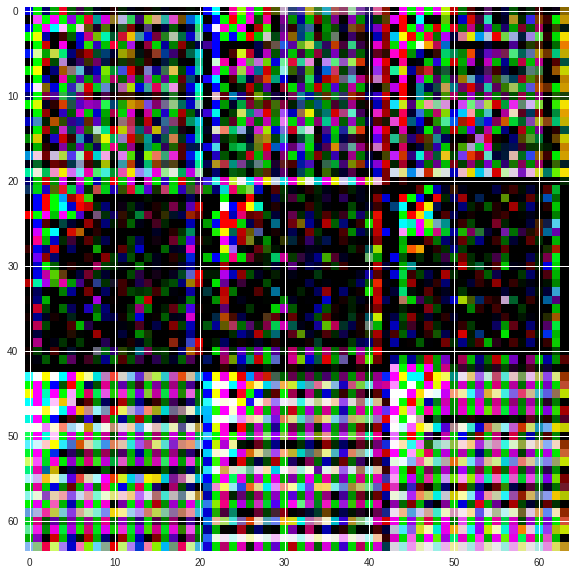

1/5, 1.5133647798742138
  G loss: 55.351295471191406
  D loss: 3.501796186355932e-07

1/5, 1.5330188679245282
  G loss: 55.37791061401367
  D loss: 7.450581485102248e-09

1/5, 1.5526729559748427
  G loss: 55.74152374267578
  D loss: 2.607715714475489e-07



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/5, 1.5723270440251573
  G loss: 55.32484817504883
  D loss: 7.450581485102248e-09



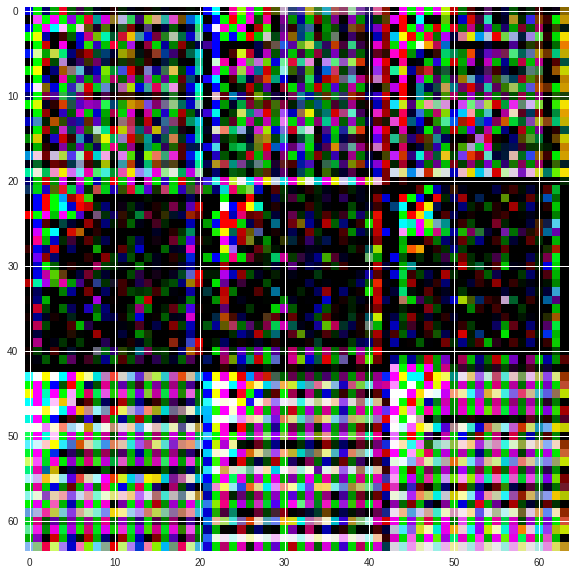

1/5, 1.5919811320754718
  G loss: 55.20432662963867
  D loss: 5.774207423314692e-08

1/5, 1.6116352201257862
  G loss: 55.261077880859375
  D loss: 1.8812741586771153e-07

1/5, 1.6312893081761006
  G loss: 55.57146453857422
  D loss: 1.862645371275562e-09



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/5, 1.650943396226415
  G loss: 55.254215240478516
  D loss: 3.725290742551124e-09



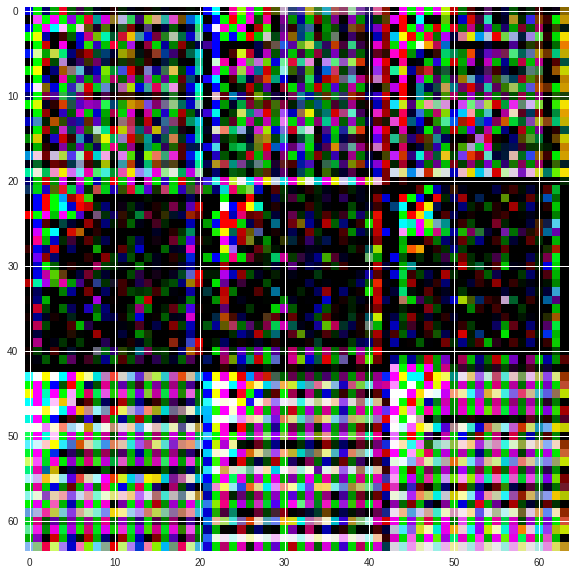

1/5, 1.6705974842767295
  G loss: 55.384002685546875
  D loss: 5.96046660916727e-08

1/5, 1.690251572327044
  G loss: 55.53535842895508
  D loss: 1.13064561446663e-06

1/5, 1.7099056603773586
  G loss: 55.460609436035156
  D loss: 4.84287880908596e-08



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/5, 1.729559748427673
  G loss: 55.468910217285156
  D loss: 1.862645371275562e-09



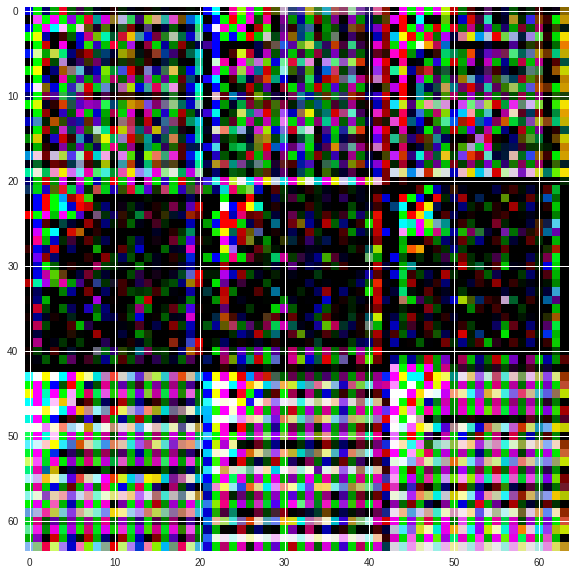

1/5, 1.7492138364779874
  G loss: 55.576133728027344
  D loss: 2.030289607546365e-07

1/5, 1.7688679245283019
  G loss: 55.730377197265625
  D loss: 2.7939680791178034e-08

1/5, 1.7885220125786163
  G loss: 55.279388427734375
  D loss: 3.3527619791584584e-08



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/5, 1.8081761006289307
  G loss: 55.48299789428711
  D loss: 2.0489170537985046e-07



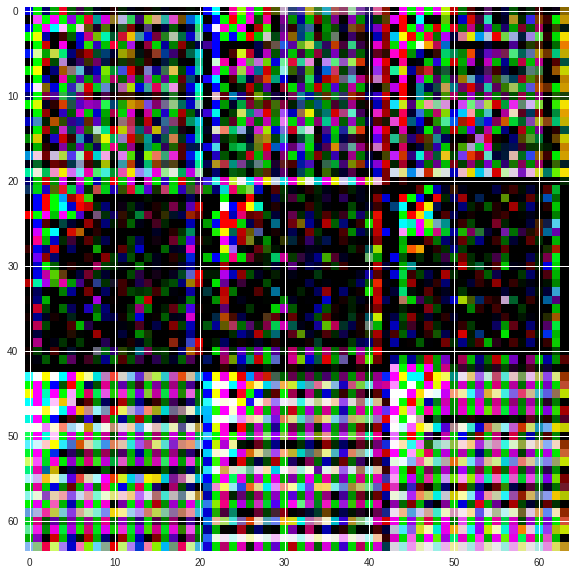

1/5, 1.8278301886792452
  G loss: 55.270545959472656
  D loss: 3.725290742551124e-09

1/5, 1.8474842767295598
  G loss: 55.27275466918945
  D loss: 3.725290742551124e-09

1/5, 1.8671383647798743
  G loss: 55.48657989501953
  D loss: 0.0



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/5, 1.8867924528301887
  G loss: 55.2021369934082
  D loss: 5.215408194203519e-08



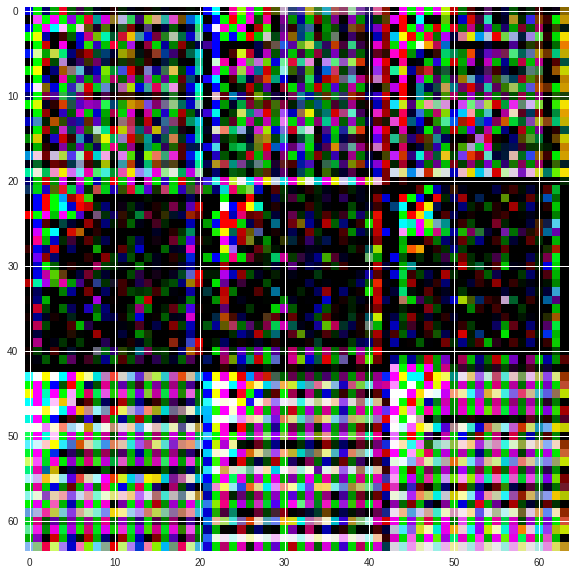

1/5, 1.9064465408805031
  G loss: 55.78677749633789
  D loss: 4.47035120032524e-08

1/5, 1.9261006289308176
  G loss: 55.46363830566406
  D loss: 2.8789809221052565e-06

1/5, 1.945754716981132
  G loss: 55.23653793334961
  D loss: 7.450581485102248e-09



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/5, 1.9654088050314464
  G loss: 55.645301818847656
  D loss: 8.568176923517967e-08



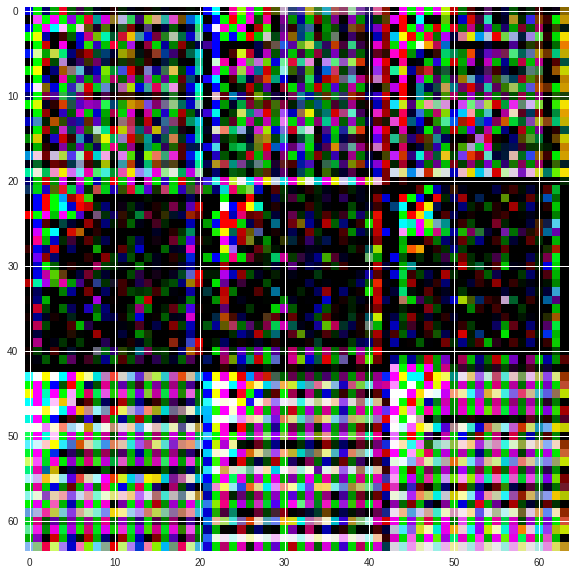

1/5, 1.985062893081761
  G loss: 55.515907287597656
  D loss: 7.450582373280668e-09

Error
2/5, 2.0047169811320753
  G loss: 55.54596710205078
  D loss: 2.6077037418303917e-08

2/5, 2.02437106918239
  G loss: 55.83293151855469
  D loss: 1.862645371275562e-09



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2/5, 2.0440251572327046
  G loss: 55.573753356933594
  D loss: 1.4901162970204496e-08



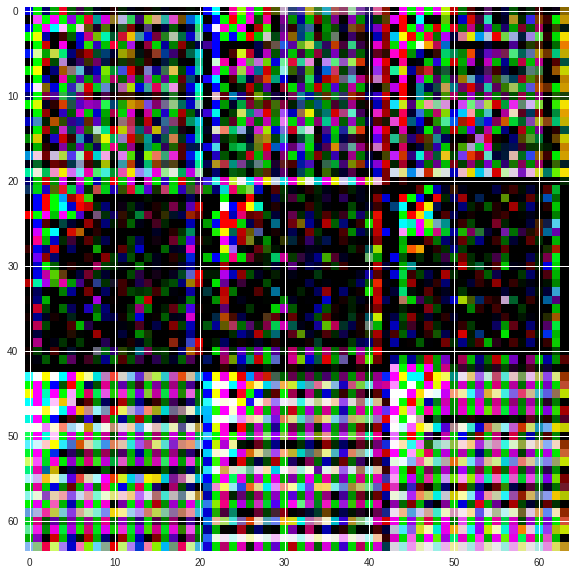

2/5, 2.063679245283019
  G loss: 55.06219482421875
  D loss: 1.564624767524947e-07

2/5, 2.0833333333333335
  G loss: 55.48944091796875
  D loss: 1.676381167214913e-08

2/5, 2.1029874213836477
  G loss: 55.241825103759766
  D loss: 2.0116678456361115e-07



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2/5, 2.1226415094339623
  G loss: 55.29630661010742
  D loss: 1.1175873559921001e-08



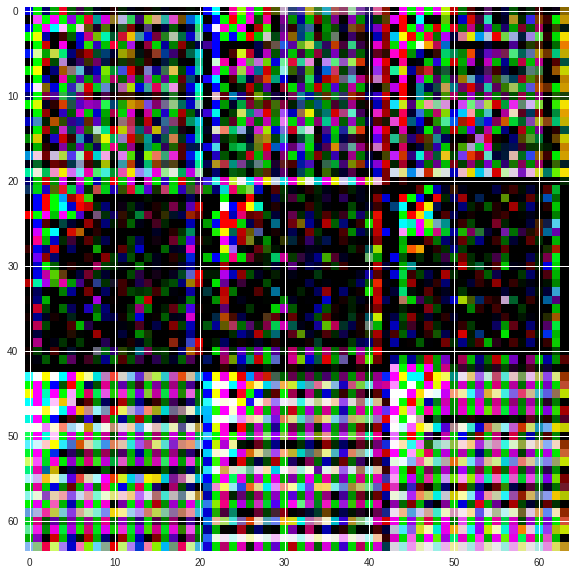

2/5, 2.1422955974842766
  G loss: 55.77360534667969
  D loss: 4.656617846876543e-08

2/5, 2.161949685534591
  G loss: 55.0980339050293
  D loss: 6.332997060098933e-08

2/5, 2.181603773584906
  G loss: 55.154457092285156
  D loss: 1.117587533627784e-08



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2/5, 2.20125786163522
  G loss: 55.3803596496582
  D loss: 4.470350134511136e-08



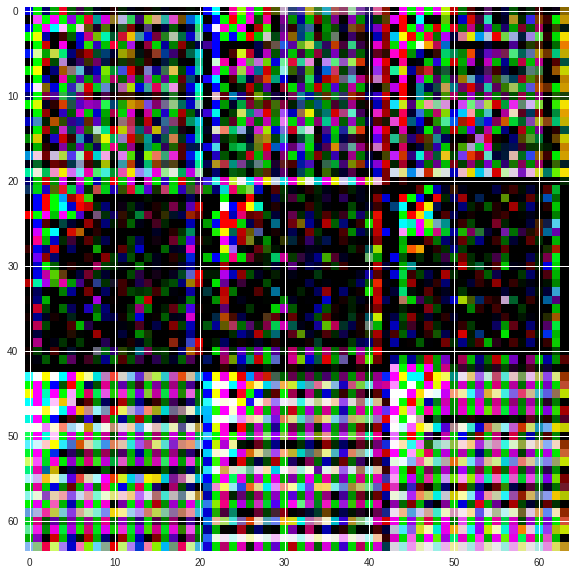

2/5, 2.2209119496855347
  G loss: 55.4830322265625
  D loss: 1.0058309385385655e-07

2/5, 2.240566037735849
  G loss: 55.64055633544922
  D loss: 0.0

2/5, 2.2602201257861636
  G loss: 55.46907424926758
  D loss: 1.1175872671742582e-08



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2/5, 2.279874213836478
  G loss: 54.92864227294922
  D loss: 1.117587533627784e-08



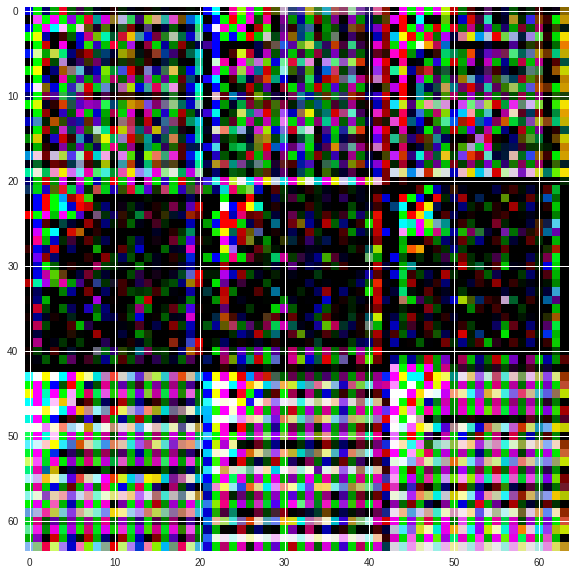

2/5, 2.2995283018867925
  G loss: 55.436546325683594
  D loss: 7.99095005277195e-07

2/5, 2.319182389937107
  G loss: 55.479949951171875
  D loss: 2.607705340551547e-08

2/5, 2.3388364779874213
  G loss: 55.53173828125
  D loss: 3.5390279151670256e-08



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2/5, 2.358490566037736
  G loss: 55.146629333496094
  D loss: 3.725290742551124e-09



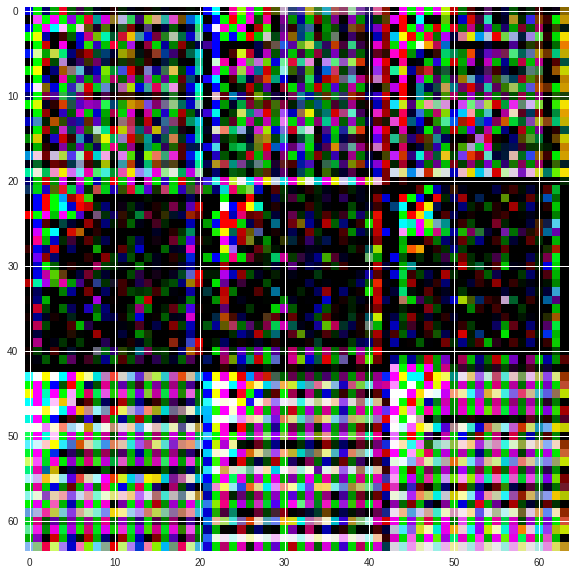

2/5, 2.37814465408805
  G loss: 55.43027114868164
  D loss: 1.56462661493606e-07

2/5, 2.397798742138365
  G loss: 55.196998596191406
  D loss: 3.725290742551124e-09

2/5, 2.417452830188679
  G loss: 55.66996383666992
  D loss: 8.009382668205944e-08



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2/5, 2.4371069182389937
  G loss: 55.058799743652344
  D loss: 3.725290742551124e-09



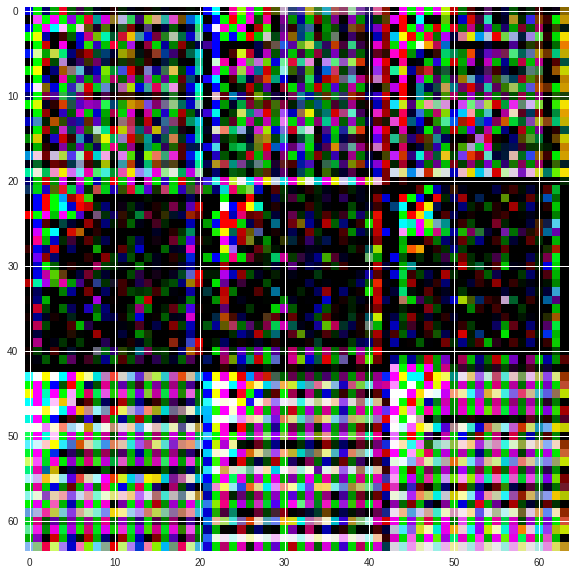

2/5, 2.4567610062893084
  G loss: 55.031585693359375
  D loss: 0.0

2/5, 2.4764150943396226
  G loss: 55.347312927246094
  D loss: 1.862645371275562e-09

2/5, 2.4960691823899372
  G loss: 55.26947784423828
  D loss: 5.532149884857063e-07



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2/5, 2.5157232704402515
  G loss: 55.034061431884766
  D loss: 1.862645371275562e-09



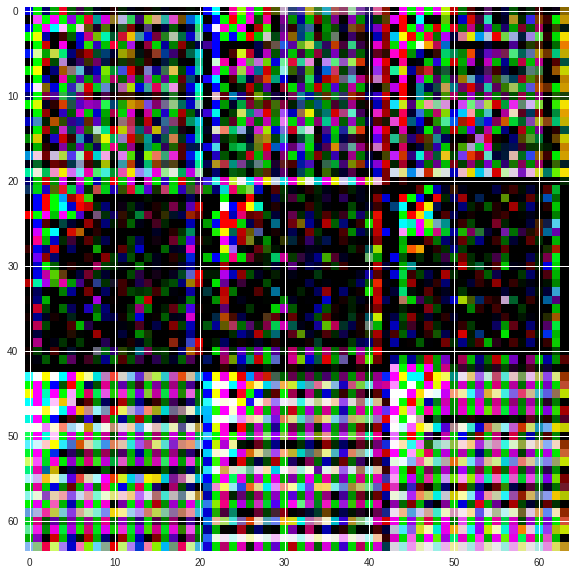

2/5, 2.535377358490566
  G loss: 55.177574157714844
  D loss: 6.146731834633101e-08

2/5, 2.5550314465408803
  G loss: 54.948890686035156
  D loss: 0.0

2/5, 2.574685534591195
  G loss: 54.790687561035156
  D loss: 0.0



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2/5, 2.5943396226415096
  G loss: 55.10425567626953
  D loss: 2.0489100194254206e-08



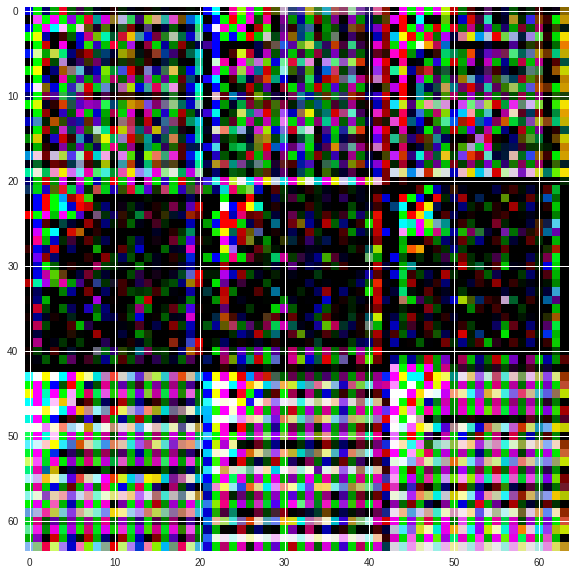

2/5, 2.613993710691824
  G loss: 55.18927001953125
  D loss: 3.725290742551124e-09

2/5, 2.6336477987421385
  G loss: 54.89847183227539
  D loss: 1.862645371275562e-09

2/5, 2.6533018867924527
  G loss: 55.51461410522461
  D loss: 7.450581485102248e-09



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2/5, 2.6729559748427674
  G loss: 55.264381408691406
  D loss: 1.862645371275562e-09



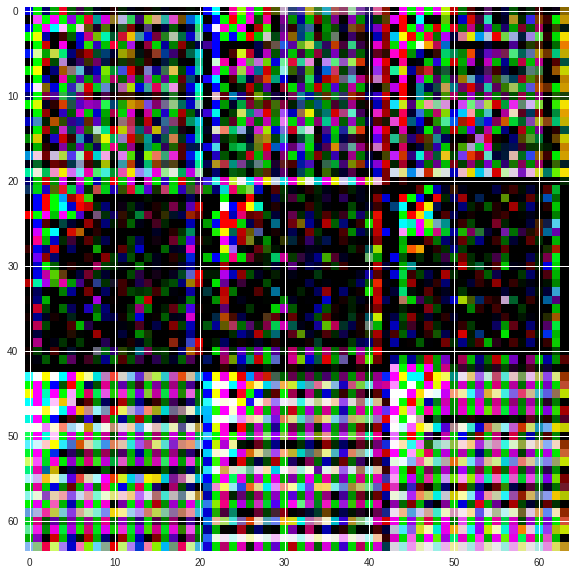

2/5, 2.6926100628930816
  G loss: 55.186920166015625
  D loss: 0.0

2/5, 2.7122641509433962
  G loss: 55.1793212890625
  D loss: 0.0

2/5, 2.731918238993711
  G loss: 55.626914978027344
  D loss: 1.862645371275562e-09



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2/5, 2.751572327044025
  G loss: 55.15290451049805
  D loss: 1.1175873559921001e-08



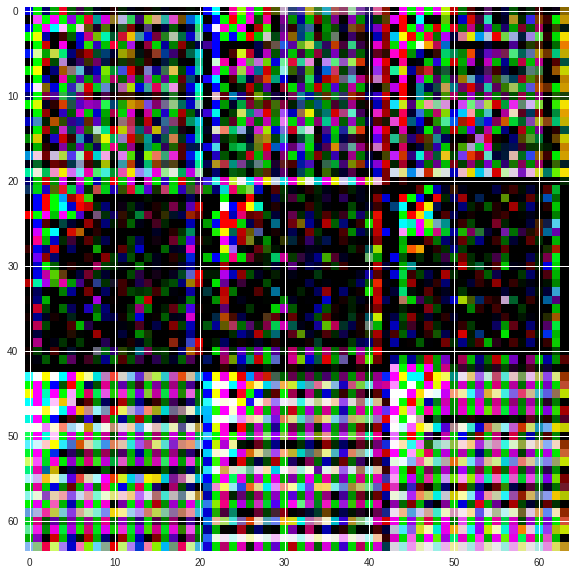

2/5, 2.7712264150943398
  G loss: 54.6995735168457
  D loss: 1.1175872671742582e-08

2/5, 2.790880503144654
  G loss: 55.43104553222656
  D loss: 1.1175872671742582e-08

2/5, 2.8105345911949686
  G loss: 55.37261962890625
  D loss: 1.6763809895792292e-08



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2/5, 2.830188679245283
  G loss: 55.034889221191406
  D loss: 1.5460004476608447e-07



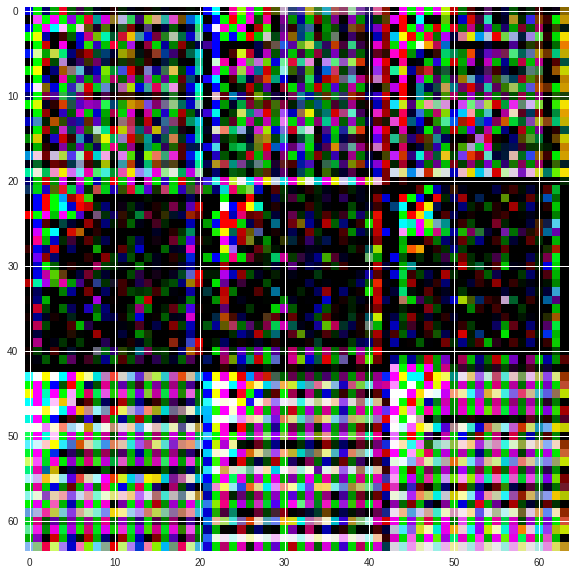

2/5, 2.8498427672955975
  G loss: 54.56855010986328
  D loss: 3.539028980981129e-08

2/5, 2.869496855345912
  G loss: 55.093231201171875
  D loss: 1.676381344850597e-08

2/5, 2.8891509433962264
  G loss: 55.09270095825195
  D loss: 0.0



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2/5, 2.908805031446541
  G loss: 55.42310333251953
  D loss: 9.313227522511625e-09



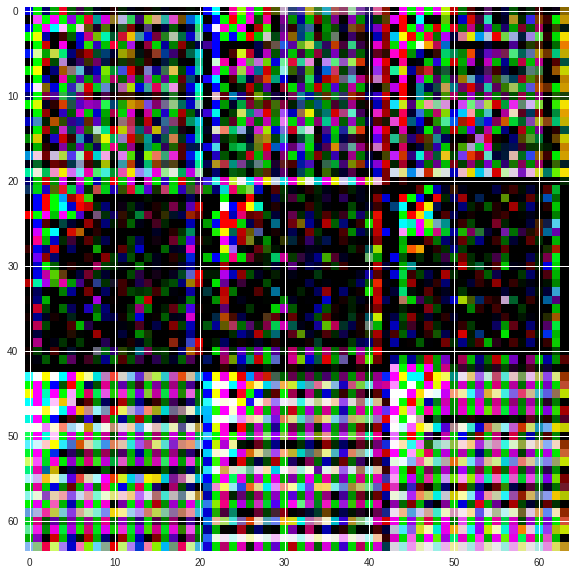

2/5, 2.9284591194968552
  G loss: 54.84126281738281
  D loss: 1.862645371275562e-09

2/5, 2.94811320754717
  G loss: 55.045074462890625
  D loss: 0.0

2/5, 2.967767295597484
  G loss: 55.17284393310547
  D loss: 3.725294206446961e-08



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2/5, 2.9874213836477987
  G loss: 55.1251106262207
  D loss: 2.4214397598143478e-08



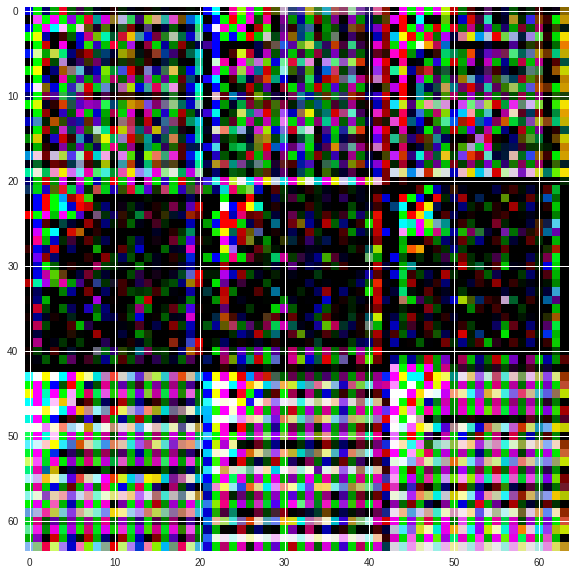

Error
3/5, 3.0070754716981134
  G loss: 55.57787322998047
  D loss: 0.0

3/5, 3.0267295597484276
  G loss: 54.73644256591797
  D loss: 9.313226634333205e-09

3/5, 3.0463836477987423
  G loss: 55.32324981689453
  D loss: 2.235175067255568e-08



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3/5, 3.0660377358490565
  G loss: 55.49765396118164
  D loss: 0.0



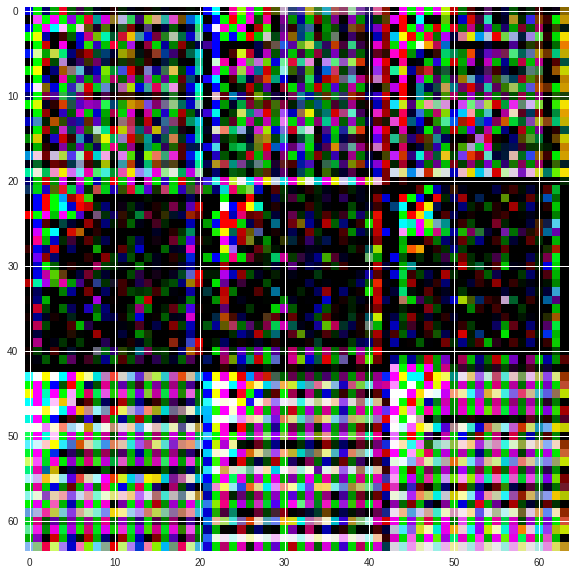

3/5, 3.085691823899371
  G loss: 55.14788818359375
  D loss: 1.1920946008103783e-07

3/5, 3.1053459119496853
  G loss: 55.33528137207031
  D loss: 5.587936335871291e-09

3/5, 3.125
  G loss: 55.053131103515625
  D loss: 3.725290742551124e-09



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3/5, 3.1446540880503147
  G loss: 55.51462173461914
  D loss: 1.862645371275562e-09



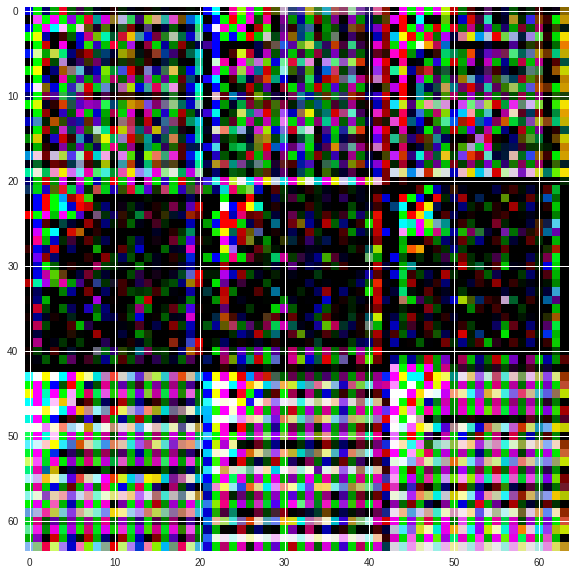

3/5, 3.164308176100629
  G loss: 55.27196502685547
  D loss: 6.519265127735707e-08

3/5, 3.1839622641509435
  G loss: 55.286354064941406
  D loss: 1.862645371275562e-09

3/5, 3.2036163522012577
  G loss: 55.50028610229492
  D loss: 1.6763809895792292e-08



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3/5, 3.2232704402515724
  G loss: 54.807098388671875
  D loss: 1.862645371275562e-09



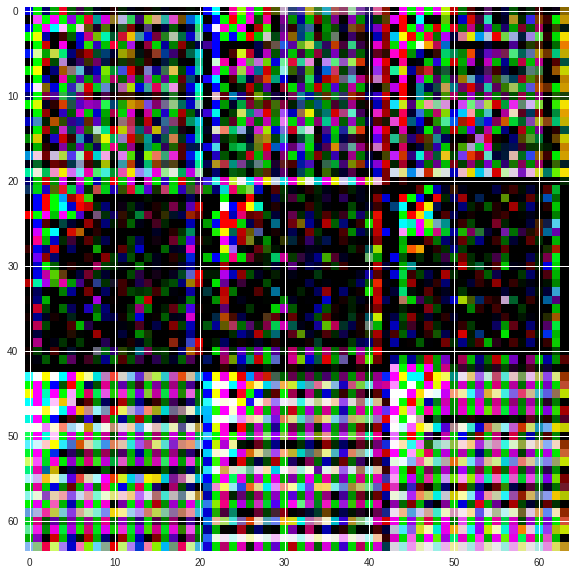

3/5, 3.2429245283018866
  G loss: 55.360355377197266
  D loss: 0.0

3/5, 3.2625786163522013
  G loss: 55.40258026123047
  D loss: 1.862645371275562e-09

3/5, 3.282232704402516
  G loss: 55.071067810058594
  D loss: 5.587936335871291e-09



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3/5, 3.30188679245283
  G loss: 55.18749237060547
  D loss: 1.862645371275562e-09



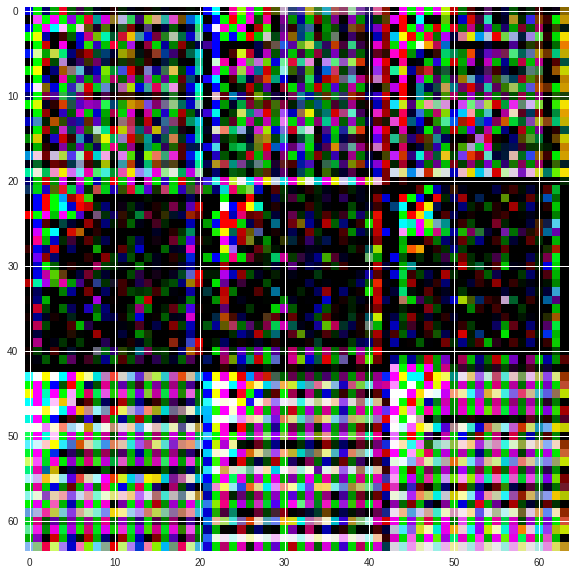

3/5, 3.3215408805031448
  G loss: 55.175743103027344
  D loss: 0.0

3/5, 3.341194968553459
  G loss: 54.910614013671875
  D loss: 1.862645371275562e-09

3/5, 3.3608490566037736
  G loss: 54.83342742919922
  D loss: 3.725290742551124e-09



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3/5, 3.380503144654088
  G loss: 55.00446319580078
  D loss: 1.862645371275562e-09



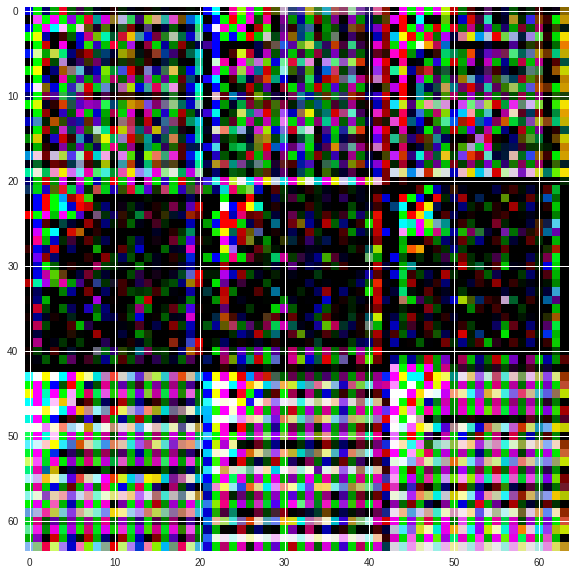

3/5, 3.4001572327044025
  G loss: 55.04661560058594
  D loss: 0.0

3/5, 3.419811320754717
  G loss: 55.21765899658203
  D loss: 0.0

3/5, 3.4394654088050314
  G loss: 55.2407112121582
  D loss: 3.725290742551124e-09



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3/5, 3.459119496855346
  G loss: 55.23040771484375
  D loss: 7.450581485102248e-09



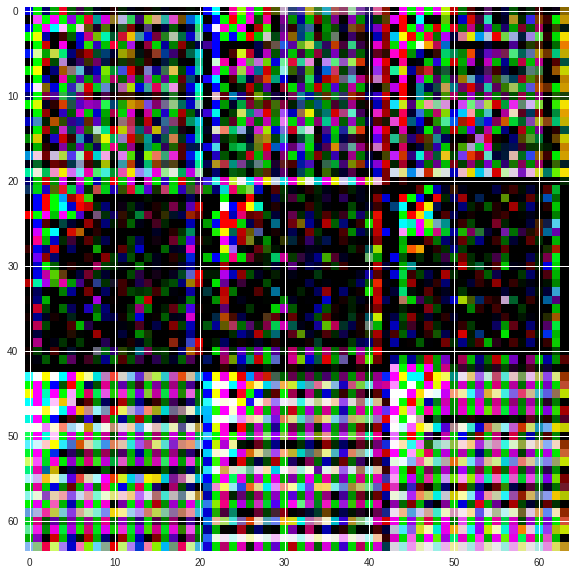

3/5, 3.4787735849056602
  G loss: 55.42441940307617
  D loss: 0.0

3/5, 3.498427672955975
  G loss: 55.101558685302734
  D loss: 9.313226634333205e-09

3/5, 3.518081761006289
  G loss: 55.028865814208984
  D loss: 1.862645371275562e-09



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3/5, 3.5377358490566038
  G loss: 54.905242919921875
  D loss: 1.862645504502325e-08



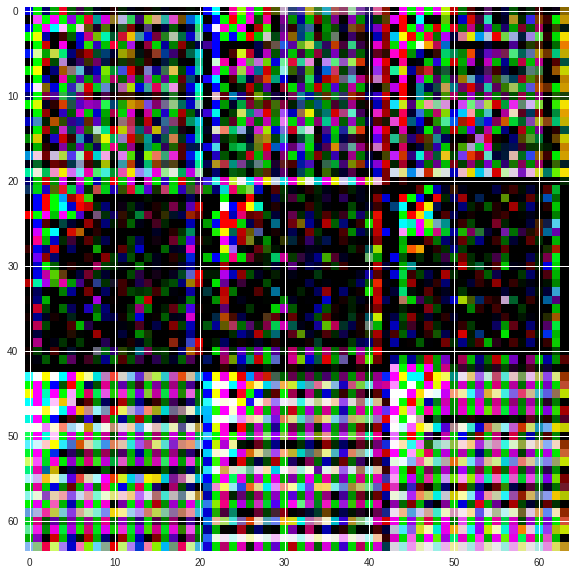

3/5, 3.5573899371069184
  G loss: 54.84238815307617
  D loss: 1.1175872671742582e-08

3/5, 3.5770440251572326
  G loss: 54.96759033203125
  D loss: 3.725290742551124e-09

3/5, 3.5966981132075473
  G loss: 54.97039794921875
  D loss: 4.097822881021784e-08



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3/5, 3.6163522012578615
  G loss: 55.016727447509766
  D loss: 0.0



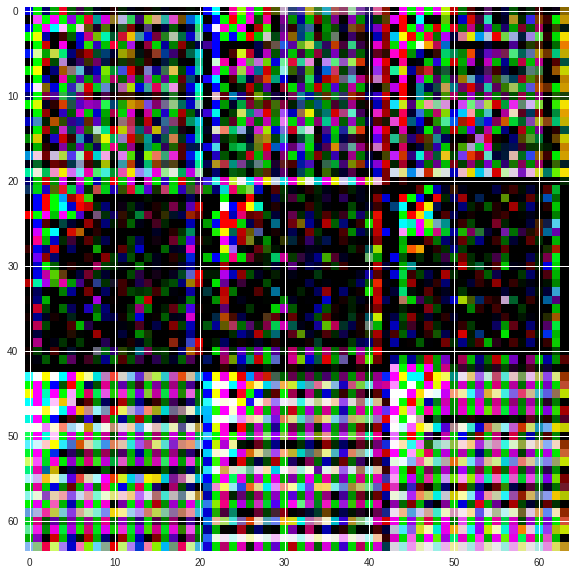

3/5, 3.636006289308176
  G loss: 54.751800537109375
  D loss: 2.235175067255568e-08

3/5, 3.6556603773584904
  G loss: 55.11351013183594
  D loss: 0.0

3/5, 3.675314465408805
  G loss: 54.982887268066406
  D loss: 7.450581485102248e-09



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3/5, 3.6949685534591197
  G loss: 55.05493927001953
  D loss: 2.0489100194254206e-08



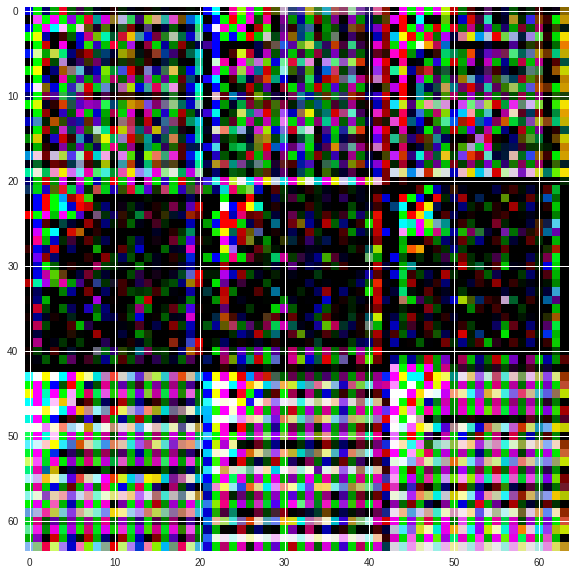

3/5, 3.714622641509434
  G loss: 54.792083740234375
  D loss: 6.705536037543425e-08

3/5, 3.7342767295597485
  G loss: 54.973819732666016
  D loss: 1.6763808119435453e-08

3/5, 3.7539308176100628
  G loss: 54.97284698486328
  D loss: 1.6763809895792292e-08



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3/5, 3.7735849056603774
  G loss: 55.3513298034668
  D loss: 2.0489105523324724e-08



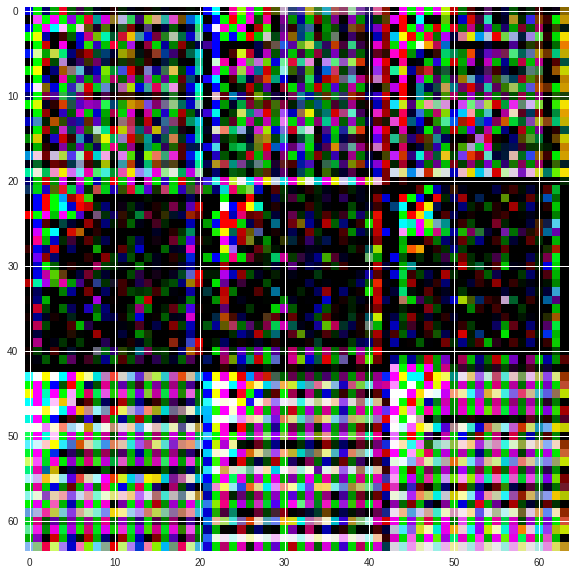

3/5, 3.7932389937106916
  G loss: 55.13317108154297
  D loss: 3.725290742551124e-09

3/5, 3.8128930817610063
  G loss: 55.218971252441406
  D loss: 3.911556234470481e-08

3/5, 3.832547169811321
  G loss: 55.30210876464844
  D loss: 2.0489110852395243e-08



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3/5, 3.852201257861635
  G loss: 54.73185729980469
  D loss: 1.862645371275562e-09



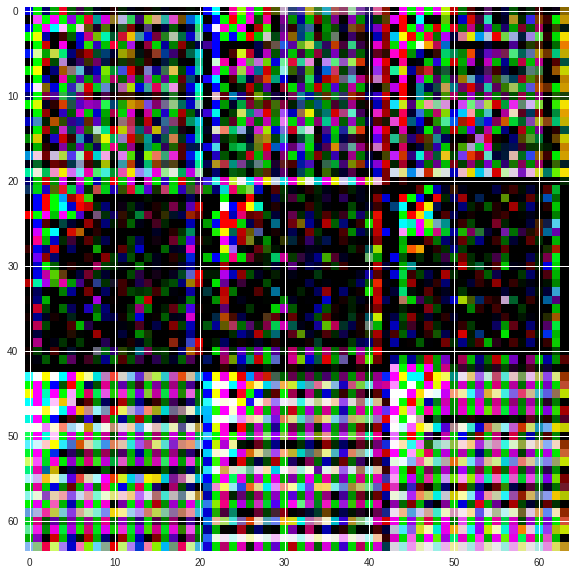

3/5, 3.87185534591195
  G loss: 54.91581726074219
  D loss: 0.0

3/5, 3.891509433962264
  G loss: 55.23929214477539
  D loss: 0.0

3/5, 3.9111635220125787
  G loss: 54.7280158996582
  D loss: 0.0



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3/5, 3.930817610062893
  G loss: 54.93239974975586
  D loss: 0.0



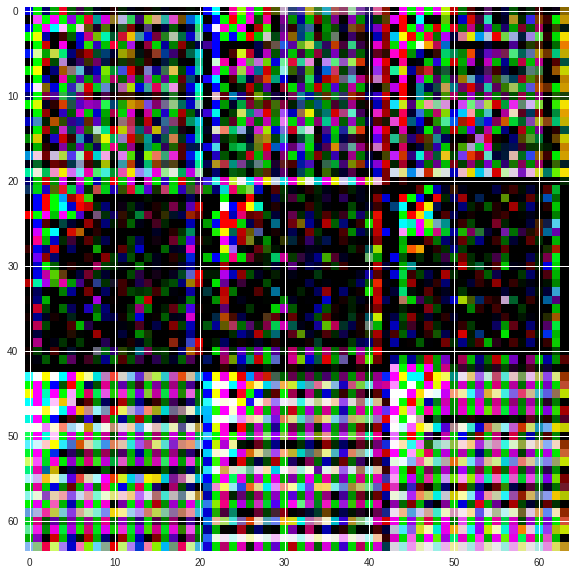

3/5, 3.9504716981132075
  G loss: 54.800987243652344
  D loss: 1.4901166522918174e-08

3/5, 3.970125786163522
  G loss: 55.16343307495117
  D loss: 0.0

3/5, 3.9897798742138364
  G loss: 55.612789154052734
  D loss: 0.0

Error


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4/5, 4.009433962264151
  G loss: 55.042266845703125
  D loss: 0.0



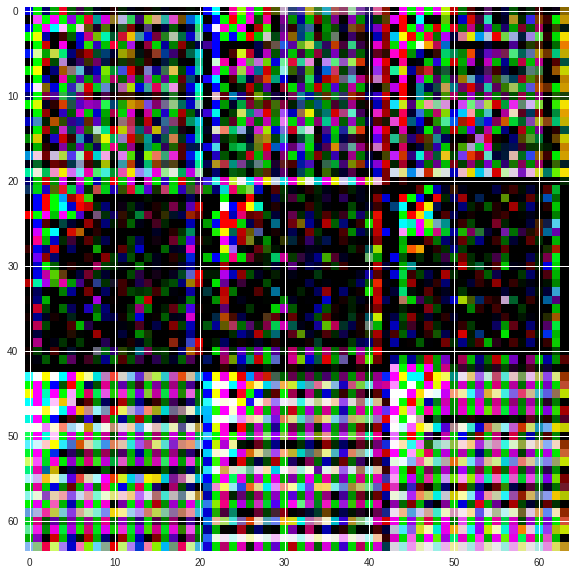

4/5, 4.029088050314465
  G loss: 55.05186462402344
  D loss: 0.0

4/5, 4.04874213836478
  G loss: 54.998558044433594
  D loss: 1.862645371275562e-09

4/5, 4.068396226415095
  G loss: 55.048095703125
  D loss: 1.862645371275562e-09



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4/5, 4.088050314465409
  G loss: 55.018455505371094
  D loss: 1.862645371275562e-09



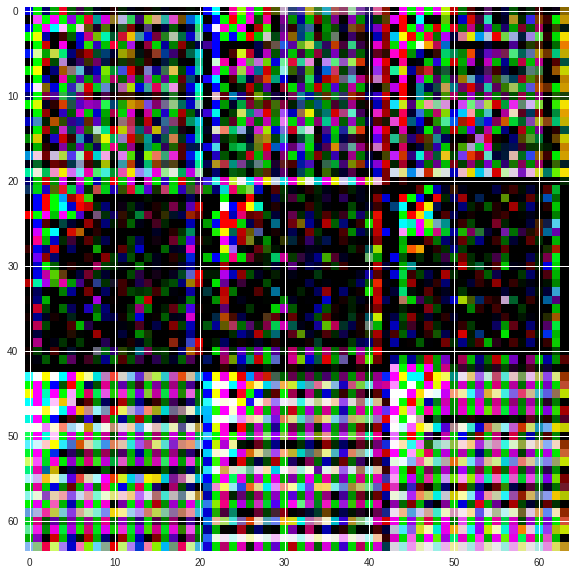

4/5, 4.107704402515723
  G loss: 54.89588928222656
  D loss: 0.0

4/5, 4.127358490566038
  G loss: 55.20445251464844
  D loss: 4.47035120032524e-08

4/5, 4.147012578616352
  G loss: 55.06801223754883
  D loss: 0.0



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4/5, 4.166666666666667
  G loss: 54.98809814453125
  D loss: 1.862645371275562e-09



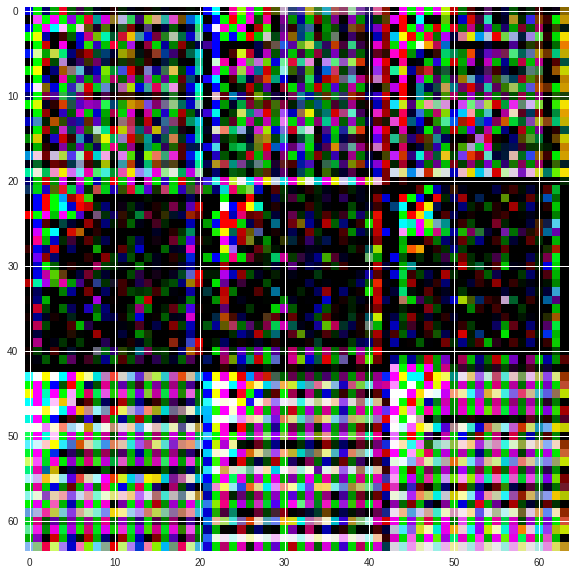

4/5, 4.186320754716981
  G loss: 55.21697235107422
  D loss: 1.862645371275562e-09

4/5, 4.205974842767295
  G loss: 55.319297790527344
  D loss: 5.587936335871291e-09

4/5, 4.22562893081761
  G loss: 54.94892120361328
  D loss: 0.0



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4/5, 4.245283018867925
  G loss: 54.74494934082031
  D loss: 1.862645371275562e-09



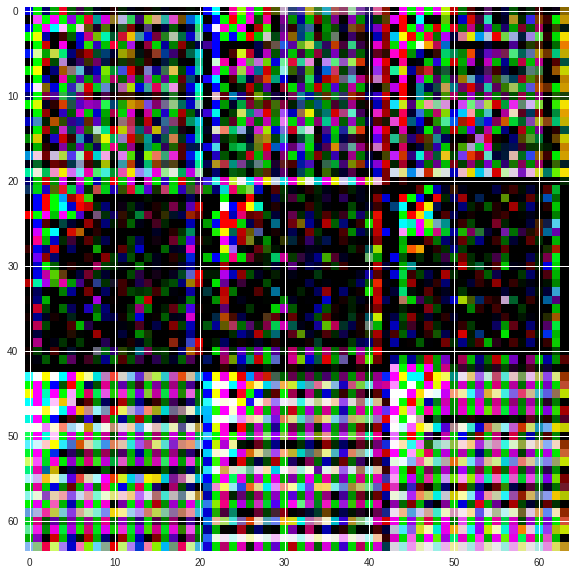

In [0]:
fixed_noise=torch.randn(1, latent_size, 1, 1).to(device)
batch_size =64

num_epochs = 5
learning_rate = 1e-3

img_list = []
G_losses = []
D_losses = []

optimizerD = optim.Adam(D.parameters(), lr=learning_rate)
optimizerG = optim.Adam(G.parameters(), lr=learning_rate)

criterion = nn.BCELoss()
i=0
for epoch in range(num_epochs):
    for (data, _) in loader:
      try:

        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

        # train with real
        batch_size-data.shape[0]
        data=data.to(device)
        D.zero_grad()
#         real_cpu = data[0].to(device)
        
        
        label = torch.full((batch_size,), 1, device=device)
        label.fill_(1)
        output = D(data)
        D_loss1 = criterion(output, label)
        D_loss1.backward()

        # train with fake
        z = torch.randn(batch_size, latent_size, 1, 1).to(device)
        fake_photo = G(z)
        label.fill_(0)
        output = D(fake_photo.detach())
        D_loss2 = criterion(output, label)
        D_loss2.backward()

        D_loss = D_loss1 + D_loss2
        optimizerD.step()

        # (2) Update G network: maximize log(D(G(z)))

        G.zero_grad()
        label.fill_(1)  # fake labels are real for generator cost
        output = D(fake_photo)
        G_loss = criterion(output, label)
        G_loss.backward()
#         torch.nn.utils.clip_grad_value_(G.parameters(), 2.5)
        optimizerG.step()
        
        if i % 50 == 0:
            # Выведем информацию о том, как наша сеть справляется
            print(f'{epoch}/{num_epochs}, {i/len(loader)}')
            print(f'  G loss: {G_loss}')
            print(f'  D loss: {D_loss}')
            print()
            
        if i % 200 == 0:
            fake = G(fixed_noise)
            img_list.append(fake)
            img_pred = to_numpy_image(fake)

            plt.figure(figsize=(10,10))
            plt.imshow(img_pred)
            plt.show()
        i+=1
      except:
        print("Error")
        



In [1]:
img_pred = to_numpy_image(img_list[0])
    # теперь это numpy-евский ndarray размера (128, 128, 3)
plt.figure(figsize=(10,10))
plt.imshow(img_pred)

NameError: ignored

In [0]:
plt.figure(figsize=(10,5))
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
# распечатайте ваши картинки

### Что дальше?

Довольно старый, но актуальный список трюков: https://github.com/soumith/ganhacks

Вообще, теория сходимости GANов очень сильно развилась за последнее время. Если хотите во всём этом разобраться, то возьмите какую-нибудь [достаточно новую статью](https://arxiv.org/pdf/1802.05957.pdf) и рекурсивно почитайте оттуда абстракты из списока литературы.